# 002. Quary Rewrite Rag with LangGraph

## Congifuration

In [22]:
from dotenv import load_dotenv
from tools import logging

import os

In [23]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [24]:
from dotenv import load_dotenv
import os
load_dotenv(override=True)

True

In [25]:
from tools import logging
logging.langsmith("quary-rewrite-RAG")

LangSmith is tracing....
[Project Name]
quary-rewrite-RAG


## PDF Retrieval Chain

In [28]:
from tools.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["data/Deepseek-r1.pdf"]).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

# 1. State Definition

In [29]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    # question: Annotated[str, "Question"] 
    question: Annotated[List[str], add_messages]
    context: Annotated[str, "Context"] 
    answer: Annotated[str, "Answer"]  
    messages: Annotated[list, add_messages] 

# 2. Node Definition

In [38]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import messages_to_history
from tools.utils import format_docs


# 1. Retrieve Node
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs)

    return {"context": retrieved_docs}


# 2. Answer Node
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    context = state["context"]
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

In [46]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Query Rewrite Prompt
with open("prompts/query_rewrite.txt", "r", encoding="utf-8") as f:
    template = f.read()

re_write_prompt = PromptTemplate(
    template=template,
    input_variables=["question"]
)

question_rewriter = (
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

In [47]:
# Query Rewrite Node
def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    return {"question": question_rewritten}

# 3. Edges

In [48]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# Query Rewrite Node
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

workflow.add_edge("query_rewrite", "retrieve")
workflow.add_edge("retrieve", "llm_answer") 
workflow.add_edge("llm_answer", END)  

workflow.set_entry_point("query_rewrite")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

# 4. Graph Visualization

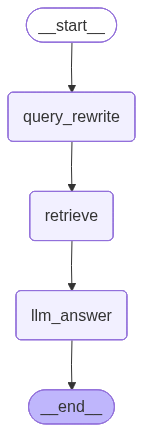

In [49]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)


# 5. Graph Execution

In [50]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

inputs = GraphState(question="What is DeepSeek-R1-Zero?")
invoke_graph(app, inputs, config)


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
What is the DeepSeek-R1-Zero technology?

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>solvingcomplexproblems,resultinginthedevelopmentofDeepSeek-R1-Zero. DeepSeek-
R1-Zero demonstrates capabilities such as self-verification, reflection, and generating
longCoTs,markingasignificantmilestonefortheresearchcommunity. Notably,itisthe</content><source>data/Deepseek-r1.pdf</source><page>4</page></document>
<document><content>spontaneousdevelopmentsignificantlyenhancesDeepSeek-R1-Zero’sreasoningcapabilities,
enablingittotacklemorechallengingtaskswithgreaterefficiencyandaccuracy.
AhaMomentofDeepSeek-R1-Zero Aparticularlyintriguingphenomenonobservedduring</content><source>data/Deepseek-r1.pdf</source><page>8</page></document>
<document><content>abilityofDeepSeek-R1-Zerotoachievesuchcompetitiveperformance,bothwithandwithout
majority voting, highlights its stro

In [51]:
stream_graph(app, inputs, config)


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What is the DeepSeek-R1-Zero technology?
🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
DeepSeek-R1-Zero is a technology that showcases advanced capabilities such as self-verification, reflection, and generating long Chains of Thought (CoTs). It enhances reasoning capabilities, enabling it to tackle challenging tasks with greater efficiency and accuracy, and achieves competitive performance without the need for supervised fine-tuning data, relying solely on reinforcement learning (RL).

**Source**
- data/Deepseek-r1.pdf (page 4)
- data/Deepseek-r1.pdf (page 7)
- data/Deepseek-r1.pdf (page 8)

In [52]:
outputs = app.get_state(config).values
outputs

{'question': [HumanMessage(content='What is DeepSeek-R1-Zero?', additional_kwargs={}, response_metadata={}, id='d1ccc3a2-0226-4bff-a0b6-862618e79449'),
  HumanMessage(content='What is the DeepSeek-R1-Zero technology?', additional_kwargs={}, response_metadata={}, id='42d19633-5abf-41a6-8543-7c6f917bf139'),
  HumanMessage(content='What is DeepSeek-R1-Zero?', additional_kwargs={}, response_metadata={}, id='6b82f44b-849d-4abe-8558-812244333b89'),
  HumanMessage(content='What is the DeepSeek-R1-Zero technology?', additional_kwargs={}, response_metadata={}, id='14805a73-1225-4203-b568-57d590bfe1f0')],
 'context': '<document><content>solvingcomplexproblems,resultinginthedevelopmentofDeepSeek-R1-Zero. DeepSeek-\nR1-Zero demonstrates capabilities such as self-verification, reflection, and generating\nlongCoTs,markingasignificantmilestonefortheresearchcommunity. Notably,itisthe</content><source>data/Deepseek-r1.pdf</source><page>4</page></document>\n<document><content>spontaneousdevelopmentsigni